In [35]:
import tensorflow as tf
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Flatten

In [36]:
from keras.applications import vgg16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

In [37]:
data = tf.keras.utils.image_dataset_from_directory('Data')

Found 86437 files belonging to 4 classes.


In [38]:
import tensorflow as tf

# Directory containing your data
data_dir = 'Data'

# Image dimensions and batch size
image_size = (256, 256)
batch_size = 32

# Create the training dataset with a validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,  # 20% of the data will be used for validation
    subset='training',
    seed=42  # Optional, for reproducibility
)

# Create the validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,  # Same validation split as the training set
    subset='validation',
    seed=42  # Optional, for reproducibility
)

# Optional: Check the class names
class_names = train_dataset.class_names
print("Class names:", class_names)


Found 86437 files belonging to 4 classes.
Using 69150 files for training.
Found 86437 files belonging to 4 classes.
Using 17287 files for validation.
Class names: ['Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia']


In [39]:
def resize_images(image, label):
    resized_image = tf.image.resize(image, (128, 128))
    return resized_image, label

# Apply the resize function to the datasets
train_dataset = train_dataset.map(resize_images)
val_dataset = val_dataset.map(resize_images)

In [40]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

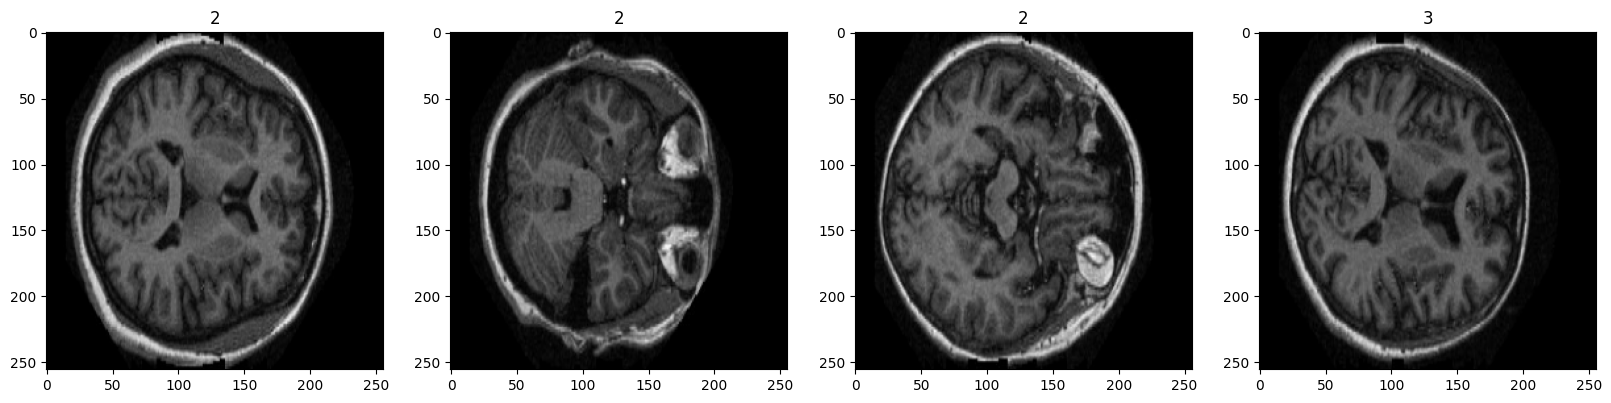

In [41]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [42]:
# Shape of Images in the dataset
batch[0][1].shape

(256, 256, 3)

In [43]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [44]:

from tensorflow.keras.utils import to_categorical

# Assuming train_dataset and val_dataset
num_classes = 4

def preprocess_data(image, label):
    # Convert label to one-hot encoding using tf.py_function
    label = tf.py_function(lambda x: to_categorical(x, num_classes=num_classes), [label], tf.float32)
    return image, label

train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

In [53]:
# CUSTOM MODEL 1
tm1 = Sequential()
tm1.add(Conv2D(32, (3, 3), 1, activation='relu', input_shape=(128, 128, 3), padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm1.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Conv2D(128, (3, 3), 1, activation='relu', padding='same'))
tm1.add(BatchNormalization())
tm1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm1.add(Dropout(0.4))

tm1.add(Flatten())
tm1.add(Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dropout(0.5))
tm1.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm1.add(Dense(4, activation="softmax"))

tm1.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                      

In [54]:
tm1.compile(optimizer='sgd', loss = 'categorical_crossentropy',metrics = ['categorical_accuracy'])

In [55]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [56]:
hist = tm1.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]
)


Epoch 1/20
2161/2161 [==============================] - 85s 39ms/step - loss: 17.4360 - categorical_accuracy: 0.7992 - val_loss: 10.9850 - val_categorical_accuracy: 0.8693
Epoch 2/20
2161/2161 [==============================] - 86s 40ms/step - loss: 7.4548 - categorical_accuracy: 0.8767 - val_loss: 4.8589 - val_categorical_accuracy: 0.9159
Epoch 3/20
2161/2161 [==============================] - 83s 38ms/step - loss: 3.2945 - categorical_accuracy: 0.9422 - val_loss: 2.1175 - val_categorical_accuracy: 0.9891
Epoch 4/20
2161/2161 [==============================] - 82s 38ms/step - loss: 1.5309 - categorical_accuracy: 0.9741 - val_loss: 1.0145 - val_categorical_accuracy: 0.9977
Epoch 5/20
2161/2161 [==============================] - 82s 38ms/step - loss: 0.7758 - categorical_accuracy: 0.9848 - val_loss: 0.5584 - val_categorical_accuracy: 0.9975
Epoch 6/20
2161/2161 [==============================] - 83s 38ms/step - loss: 0.4521 - categorical_accuracy: 0.9881 - val_loss: 0.3503 - val_categor

In [65]:
tm1.save('tm1.h5')

In [61]:
tm2 = Sequential()
tm2.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape =(128,128,3), padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

tm2.add(Conv2D(32, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Conv2D(64, (3, 3), 1, activation='relu', padding='same'))
tm2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
tm2.add(Dropout(0.5))

tm2.add(Flatten())
tm2.add(Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
tm2.add(Dense(4, activation="softmax"))
tm2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 64)      

In [62]:
tm2.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['categorical_accuracy'])

In [63]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [64]:
hist = tm2.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[tensorboard_callback]
)


Epoch 1/20
2161/2161 [==============================] - 136s 62ms/step - loss: 2.6436 - categorical_accuracy: 0.7859 - val_loss: 0.5393 - val_categorical_accuracy: 0.8385
Epoch 2/20
2161/2161 [==============================] - 46s 21ms/step - loss: 0.4850 - categorical_accuracy: 0.8759 - val_loss: 0.4214 - val_categorical_accuracy: 0.9047
Epoch 3/20
2161/2161 [==============================] - 46s 21ms/step - loss: 0.3955 - categorical_accuracy: 0.9201 - val_loss: 0.3006 - val_categorical_accuracy: 0.9592
Epoch 4/20
2161/2161 [==============================] - 46s 21ms/step - loss: 0.3629 - categorical_accuracy: 0.9332 - val_loss: 0.2986 - val_categorical_accuracy: 0.9615
Epoch 5/20
2161/2161 [==============================] - 46s 21ms/step - loss: 0.3412 - categorical_accuracy: 0.9426 - val_loss: 0.2485 - val_categorical_accuracy: 0.9789
Epoch 6/20
2161/2161 [==============================] - 46s 21ms/step - loss: 0.3293 - categorical_accuracy: 0.9484 - val_loss: 0.2658 - val_categori

In [66]:
tm2.save('tm2.h5')